# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape, Activation
from keras.models import Model, Sequential
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.activations import softmax
from keras.objectives import binary_crossentropy as bce
from keras.objectives import mean_squared_error as mse


%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# Model

In [2]:
def sampling(logits_y):
    U = K.random_uniform(K.shape(logits_y), 0, 1)
    y = logits_y - K.log(-K.log(U + 1e-20) + 1e-20) # logits + gumbel noise
    y = softmax(K.reshape(y, (-1, N, M)) / tau)
#     y = softmax(K.reshape(y, (N, M)) / tau,axis=-1)
    y = K.reshape(y, (-1, N*M))
    return y


# def gumbel_loss(x, x_hat):
#     q_y = K.reshape(logits_y, (-1, N, M))
#     q_y = softmax(q_y)
#     log_q_y = K.log(q_y + 1e-20)
#     kl_tmp = q_y * (log_q_y - K.log(1.0/M))
#     KL = K.sum(kl_tmp, axis=(1, 2))
# #     elbo = data_dim * bce(x, x_hat) - KL 
#     elbo = DATA_DIM * bce(x, x_hat) - KL
#     return elbo

# def gumbel_loss(x, x_hat):
#     print(K.shape(logits_y))
#     q_y = K.reshape(logits_y, (-1, N, M))
#     print(K.shape(logits_y))
#     q_y = softmax(q_y)
#     log_q_y = K.log(q_y + 1e-20)
#     kl_tmp = q_y * (log_q_y - K.log(1.0/M))
#     KL = K.sum(kl_tmp, axis=(1, 2))
# #     elbo = data_dim * bce(x, x_hat) - KL 
#     elbo = DATA_DIM * bce(x, x_hat) - KL
#     return elbo

def gumbel_loss(x, x_hat):
    q_y = K.reshape(logits_y, (-1, N, M))
    q_y = softmax(q_y)
    log_q_y = K.log(q_y + 1e-20)
    kl_tmp = q_y * (log_q_y - K.log(1.0/M))
    KL = K.sum(kl_tmp, axis=(1, 2))
    x = K.reshape(x, (1,-1))
    x_hat = K.reshape(x_hat, (1,-1))
#     elbo = DATA_DIM * bce(x, x_hat) - KL
    elbo = DATA_DIM * mse(x, x_hat) - KL
    return elbo




In [70]:
batch_size = 100
DATA_DIM = 784
M = 15
N = 10
nb_epoch = 30 #100
epsilon_std = 0.01

anneal_rate = 0.0003
min_temperature = 0.5

In [71]:

tau = K.variable(5.0, name="temperature")
# tau = K.variable(2.5, name="temperature")

# x = Input(batch_shape=(batch_size, DATA_DIM))
x = Input(shape=( 784, ))
h = Dense(256, activation='relu')(Dense(512, activation='relu')(x))
logits_y = Dense(M*N, activation='relu', name="logits_y")(h)

# z = Lambda(sampling, output_shape=(M*N,))(logits_y)

z_lay = Lambda(sampling, output_shape=(M*N,))
z = z_lay(logits_y)
z_ = Activation(None)(z)
generator = Sequential()
generator.add(Dense(256, activation='relu', input_shape=(N*M, )))
generator.add(Dense(512, activation='relu'))
generator.add(Dense(DATA_DIM, activation='sigmoid'))
x_hat = generator(z)

# x_hat = Dense(data_dim, activation='softmax')(Dense(512, activation='relu')(Dense(256, activation='relu')(z)))

vae = Model(x, x_hat)
vae_test = Model(x, [x_hat, logits_y, z_])

vae.compile(optimizer='adam', loss=gumbel_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
logits_y (Dense)             (None, 150)               38550     
_________________________________________________________________
lambda_17 (Lambda)           (None, 150)               0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 784)               572432    
Total params: 1,144,230
Trainable params: 1,144,230
Non-trainable params: 0
_________________________________________________________________


# Model 2

In [10]:
batch_size = 64
INPUT_DIM = (28,28,1)
DATA_DIM = 784 # MNIST: 28x28x1
M = 7 #10
N = 42 #30
nb_epoch = 50 #100
epsilon_std = 0.01

anneal_rate = 0.0003
min_temperature = 0.1 #0.5

In [11]:
tau = K.variable(5.0, name="temperature")
ACTIV = "relu"

# x = Input(batch_shape=(batch_size, data_dim ))
x = Input(shape=INPUT_DIM)
# h = Dense(256, activation='relu')(Dense(512, activation='relu')(x))
h = Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation=ACTIV)(x)
h = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation=ACTIV)(h)
# h = Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation=ACTIV)(h)
h = Flatten()(h)

logits_y = Dense(M*N, activation=None)(h)


# z = Lambda(sampling, output_shape=(M*N,))(logits_y)

z_lay = Lambda(sampling, output_shape=(M*N,))
z = z_lay(logits_y)
z_ = Activation(None)(z)

# generator = Sequential()
# generator.add(Dense(256, activation='relu', input_shape=(N*M, )))
# generator.add(Dense(512, activation='relu'))
# generator.add(Dense(data_dim, activation='sigmoid'))
# x_hat = generator(z)

z_dec = Reshape( (M,M,-1), input_shape=(N*M,) )
z_h = Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding="same", activation=ACTIV)
z_h2 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation=ACTIV)
x_hat = Conv2D(filters=1, kernel_size=3, strides=1, padding="same", activation="sigmoid")
# x_hat = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding="same", activation="sigmoid")

# generator = Sequential()
# generator.add( z_dec )
# generator.add( z_h )
# generator.add( z_h2 )
# generator.add( z_h3 )
# x_hat = generator(z)

# x_hat = Dense(data_dim, activation='softmax')(Dense(512, activation='relu')(Dense(256, activation='relu')(z)))

decoded_x = x_hat(z_h2(z_h(z_dec( z ))))

decode_input = Input( shape=(M*N,) )
decoder = x_hat(z_h2(z_h(z_dec( decode_input ))))
generator = Model(decode_input, decoder)

vae_test = Model(x, [decoded_x, logits_y, z_])
vae = Model(x, decoded_x)
vae.compile(optimizer='adam', loss=gumbel_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        544       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          32832     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 294)               922278    
_________________________________________________________________
lambda_2 (Lambda)            (None, 294)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 6)           0         
__________

# Model 3

In [10]:
batch_size = 64
INPUT_DIM = (64,64,3)
DATA_DIM = 12288 # MNIST: 28x28x1
M = 8
N = 12
nb_epoch = 50 #100
epsilon_std = 0.01

anneal_rate = 0.0003
min_temperature = 0.5

In [11]:
tau = K.variable(5.0, name="temperature")
ACTIV = "relu"

# x = Input(batch_shape=(batch_size, data_dim ))
x = Input(shape=INPUT_DIM)
# h = Dense(256, activation='relu')(Dense(512, activation='relu')(x))
h = Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation=ACTIV)(x)
h = Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation=ACTIV)(h)
# h = Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation=ACTIV)(h)
h = Flatten()(h)

logits_y = Dense(M*N, activation=None)(h)

# z = Lambda(sampling, output_shape=(M*N,))(logits_y)
z_lay = Lambda(sampling, output_shape=(M*N,))
z = z_lay(logits_y)
z_ = Activation(None)(z)

# z = Reshape((1,1,N*M))(z)
# z = Conv2DTranspose(filters=32, kernel_size=6, strides=4, padding="same")(z)
# z = Conv2DTranspose(filters=32, kernel_size=3, strides=4, padding="same")(z)
# z = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same")(z)
# x_hat = Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="same")(z)

z_1 = Reshape((1,1,N*M))
z_2 = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_3 = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_4 = Conv2DTranspose(filters=16, kernel_size=4, strides=2, padding="same", activation=ACTIV)
z_5 = Conv2DTranspose(filters=16, kernel_size=4, strides=4, padding="same", activation=ACTIV)
x_hat = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding="same", activation="sigmoid")

decoded_x = x_hat(z_5(z_4(z_3(z_2(z_1( z ))))))


# x_hat = Dense(data_dim, activation='softmax')(Dense(512, activation='relu')(Dense(256, activation='relu')(z)))

decode_input = Input( shape=(M*N,) )
decoder = x_hat(z_5(z_4(z_3(z_2(z_1( decode_input ))))))
generator = Model(decode_input, decoder)

vae_test = Model(x, [decoded_x, logits_y, z_])
vae = Model(x, decoded_x)
vae.compile(optimizer='adam', loss=gumbel_loss)
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                1572960   
_________________________________________________________________
lambda_2 (Lambda)            (None, 96)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, 96)          0         
__________

# Train

## import data

In [12]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# vectorize
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) 
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# give extra third dimensioin
x_train = x_train.reshape( (len(x_train),28,28,1  ) )
x_test = x_test.reshape( (len(x_test),28,28,1  ) )

# reduce data set size
x_train = x_train[:10000]
x_test = x_test[:2000]

print(x_train.shape, x_test.shape)

(10000, 28, 28, 1) (2000, 28, 28, 1)


## race car data

In [5]:
import os
data_dir = "world_models_data"
data1 = "small_obs_data_car_racing_1.npy"
np_dat = np.load(os.path.join(data_dir, data1))

In [6]:
x_train = np_dat[:8000]
x_test = np_dat[8000:]
print(x_train.shape, x_test.shape)

(8000, 64, 64, 3) (2000, 64, 64, 3)


## Training

In [12]:
for e in range(nb_epoch):
    print(e, "/", nb_epoch)
    train_hist = vae.fit(x_train, x_train, 
        shuffle=True, 
        epochs=1, 
        batch_size=batch_size,
        validation_data=(x_test, x_test))
    K.set_value(tau, np.max([K.get_value(tau) * np.exp(- anneal_rate * e), min_temperature]))

0 / 50
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 4s 510us/step - loss: 528.2675 - val_loss: 338.8983
1 / 50
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 3s 418us/step - loss: 150.6017 - val_loss: 132.0448
2 / 50
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 3s 435us/step - loss: 88.1371 - val_loss: 99.3534
3 / 50
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 3s 416us/step - loss: 68.4500 - val_loss: 81.2372
4 / 50
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 3s 433us/step - loss: 52.6427 - val_loss: 67.9571
5 / 50
Train on 8000 samples, validate on 2000 samples
Epoch 1/1
8000/8000 [==============================] - 3s 404us/step - loss: 42.4511 - val_loss: 56.5604
6 / 50
Train on 8000 samples, valida

## Save model weights

In [101]:
# vae.save_weights('model3_vae_weights.h5')

# Visualize results

In [13]:
argmax_y = K.max(K.reshape(logits_y, (-1, N, M)), axis=-1, keepdims=True)
argmax_y = K.equal(K.reshape(logits_y, (-1, N, M)), argmax_y)
# encoder = K.function([x], [argmax_y, x_hat])
encoder = K.function([x], [argmax_y, decoded_x])


(<matplotlib.image.AxesImage at 0x18a0aa25860>, (-0.5, 63.5, 63.5, -0.5))

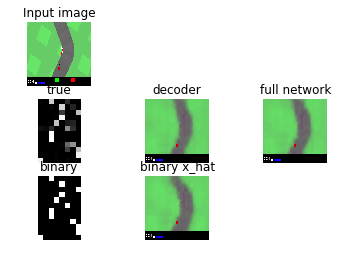

In [14]:
# test_idx, try: from 160-180
test_idx = 171
_batch = 300
code, x_hat_test = encoder([x_test[:_batch]])

_x_hat, _logits, _z = vae_test.predict(x_test[:_batch])

subplot(331)
title("Input image")
# imshow(x_test[test_idx].reshape(28, 28), cmap='gray'), axis('off')
imshow(x_test[test_idx].reshape(64, 64, 3), cmap='gray'), axis('off')

subplot(334)
title("true")
imshow(_z[test_idx].reshape(N, M), cmap='gray'), axis('off')

subplot(335)
title("decoder")
img_true = generator.predict(np.reshape(_z[test_idx], (1,-1)) )
# imshow(img_true.reshape(28, 28), cmap='gray'), axis('off')
imshow(img_true.reshape(64, 64, 3), cmap='gray'), axis('off')

subplot(336)
title("full network")
# imshow(x_hat_test[test_idx].reshape(28, 28), cmap='gray'), axis('off')
imshow(x_hat_test[test_idx].reshape(64, 64, 3), cmap='gray'), axis('off')


# imshow(x_hat_test[test_idx].reshape(28, 28), cmap='gray'), axis('off')
# imshow(x_hat_test[test_idx].reshape(64, 64, 3), cmap='gray'), axis('off')

subplot(337)
title("binary")
imshow(code[test_idx].reshape(N, M), cmap='gray'), axis('off')

subplot(338)
title("binary x_hat")
img_binary = generator.predict(np.reshape(code[test_idx], (1,-1)) )
# imshow(img_binary.reshape(28, 28), cmap='gray'), axis('off')
imshow(img_binary.reshape(64, 64, 3), cmap='gray'), axis('off')




# Create sample 1.0

In [70]:
%matplotlib inline
from ipywidgets import interactive
from ipywidgets import widgets
from IPython.display import display

In [74]:
# N = 10
# M = 5

img_code = np.zeros( (N,M) )

def f(*args,**kwargs):
#     print(kwargs)
    for i, key in enumerate(kwargs):
#         print( kwargs[key] )
        zero_row = np.zeros((1,M))
        zero_row[0, kwargs[key] ] = 1
        img_code[i] = zero_row
    
    plt.subplot(121)
    plt.imshow(img_code, cmap="gray")
    
    plt.subplot(122)
    img_binary = generator.predict(np.reshape(img_code, (1,-1)) )
#     plt.imshow(img_binary.reshape(28, 28), cmap='gray')
    plt.imshow(img_binary.reshape(64, 64, 3), cmap='gray')
    plt.axis('off')


kw_dict = {}
for n in range(N):
    kw_dict["z"+str(n)] = widgets.IntSlider(description="z"+str(n), min=0, max=(M-1), value=int(M/2), continuous_update=False)

interactive_plot = interactive(f, **kw_dict)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=2, continuous_update=False, description='z7', max=3), IntSlider(value=2,…

# Create sample 2.0

(<matplotlib.image.AxesImage at 0x1de17e4a198>, (-0.5, 9.5, 29.5, -0.5))

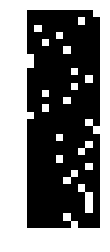

In [430]:
sample = np.zeros( (N,M) )

for i in range(N):
    sample[i, np.random.randint(0,M)] = 1.0

# print(sample)
# imshow(sample, cmap='gray'), axis('off')
imshow(code[test_idx].reshape(N, M), cmap='gray'), axis('off')

In [257]:
# def softmaxx(x):
#     """Compute softmax values for each sets of scores in x."""
#     return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmaxx(x):
    """Compute softmax values for each sets of scores in x."""
    arr = []
    for row in x:
        e_x = np.exp(row - np.max(row))
        e_x = e_x / e_x.sum()
        arr.append(e_x)
#         print(e_x)
    return np.asarray(arr)


def sampl(logits_y, tau):
#     U = K.random_uniform(K.shape(logits_y), 0, 1)
#     print("LOGITS_Y")
#     print(logits_y)
    U = np.random.uniform(0, 1, logits_y.shape)
#     print("U !!!")
#     print(U)
    y = logits_y - np.log(-np.log(U + 1e-20) + 1e-20) # logits + gumbel noise
#     print("y: logits minus gumbel")
#     print(y)
    y = softmaxx(np.reshape(y, (-1, N, M)) / tau)
#     print("y after softmax")
#     print(y)
    y = np.reshape(y, (-1, N*M))
#     print("y after reshape")
#     print(y)
    return y



In [ ]:
def sample_gumbel(shape, eps=1e-20): 
  """Sample from Gumbel(0, 1)"""
  U = tf.random_uniform(shape,minval=0,maxval=1)
  return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
  """ Draw a sample from the Gumbel-Softmax distribution"""
  y = logits + sample_gumbel(tf.shape(logits))
  return tf.nn.softmax( y / temperature)


In [120]:
a = sampl( np.random.rand(M*N), 0.1 )
# b = sampl( np.random.rand(M*N)*100, 0.1 )
# c = sampl( np.zeros((1,M*N)), 0.1 )

# b = np.reshape(b, (N,M))
# b




LOGITS_Y
[ 0.34383575  0.94892719  0.42020285  0.95438047  0.87347585  0.571351
  0.13958841  0.56617047  0.463364    0.41711555  0.92501778  0.74537507
  0.78030203  0.57333708  0.88866286  0.77348239  0.40044252  0.52112064
  0.96502015  0.16092027  0.05671647  0.17942218  0.99459745  0.80318646
  0.76559526  0.53798436  0.64749067  0.84097111  0.90487155  0.5699846
  0.27000314  0.18780187  0.91074068  0.87836262  0.94238966  0.08558775
  0.47190035  0.87476978  0.83202187  0.44219694  0.0422646   0.41115651
  0.00842397  0.72800203  0.11273228  0.45575335  0.29622134  0.09444701
  0.8617085   0.02848176  0.41319634  0.04314811  0.16704191  0.82344977
  0.51225001  0.81893367  0.08099949  0.86070965  0.80678421  0.77462458
  0.11124669  0.68586619  0.65344374  0.86040751  0.90271618  0.66211689
  0.97129203  0.71446682  0.79617341  0.88864883  0.51802012  0.00172061
  0.25666503  0.30997656  0.36319418  0.12101082  0.85507319  0.59306272
  0.71723007  0.44005196  0.61931873  0.08814

In [121]:
# code, x_hat_test = encoder([x_test[:1]])
rand_code = np.eye(M)[np.random.choice(M, N)]
rand_img = generator.predict(np.reshape(rand_code, [-1,N*M]))
sampl_code = bli
sampl_img =  generator.predict(np.reshape(sampl_code, [-1,N*M]))

ValueError: cannot reshape array of size 12 into shape (300)

In [122]:
# img_reshaped = rand_img.reshape(28,28)
img_reshaped = sampl_img.reshape(28,28)
img_reshaped.shape
plt.imshow(img_reshaped, cmap="gray")

NameError: name 'sampl_img' is not defined